In [2]:
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm.notebook import tqdm

In [3]:
torch.cuda.empty_cache()

# Load Data

In [4]:
train_images = np.load('/space/data/mnist/train_data.npy')
mean = np.mean(train_images)
std = np.std(train_images)
train_images = (train_images - mean)/std
# train_labels = np.load('/space/data/mnist/train_labels.npy')
val_images = np.load('/space/data/mnist/val_data.npy')
val_images = (val_images - mean)/std

In [4]:
train_images[1]

array([[-0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389],
       [-0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389],
       [-0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.42407389, -0.42407389, -0.42407389, -0.42407389,
        -0.42407389, -0.4240

In [5]:
# Move the new model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
BATCH_SIZE = 640
torch_X_train = torch.from_numpy(train_images).type(torch.LongTensor)
torch_X_test = torch.from_numpy(val_images).type(torch.LongTensor)

#expand dim for cnn
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()


# data loader
trainloader = torch.utils.data.DataLoader(torch_X_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(torch_X_test, batch_size = 20, shuffle = True)

In [7]:
print("Total number of batches in trainloader: = {}".format(len(trainloader)))
print("Total number of batches in testloader: = {}".format(len(test_loader)))

Total number of batches in trainloader: = 94
Total number of batches in testloader: = 500


# Model Architecture

## Encoder Architecture

In [7]:
def get_encoder_block(in_channels, out_channels,kernel_size, stride,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels, kernel_size,stride,padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.block_1 = get_encoder_block(1,16,(3,3),1)
        self.block_2 = get_encoder_block(16,32,(3,3),1)
        self.block_3 = get_encoder_block(32,64,(3,3),1)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features = 30976, out_features = 15488)
        self.linear2 = nn.Linear(in_features = 15488, out_features = 32)
    
    def forward(self,images):
        out = self.block_1(images)
        out = self.block_2(out)
        out = self.block_3(out)
#         print(out.shape)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.linear2(out)
        
        return out

## Decoder Architecture

In [9]:
def get_decoder_block(in_channels, out_channels, kernel_size, stride, padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )


In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(in_features=32, out_features=15488)
        self.linear2 = nn.Linear(in_features=15488, out_features=30976)

        # Define transpose convolutional layers (deconvolutional layers)
        self.deconv_3 = get_decoder_block(64, 32, kernel_size=(3, 3), stride=1)
        self.deconv_2 = get_decoder_block(32, 16, kernel_size=(3, 3), stride=1)
        self.deconv_1 = get_decoder_block(16, 1, kernel_size=(3, 3), stride=1)  # Adjust the kernel size and stride

    def forward(self, encoded_features):
        out = self.linear1(encoded_features)
        out = self.linear2(out)
        out = out.view(-1, 64, 22, 22)  # Reshape to match the shape of the last convolutional layer in the encoder
        out = self.deconv_3(out)
        out = self.deconv_2(out)
        out = self.deconv_1(out)
        return out

## AutoEncoder Architecture

In [11]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
# Model Initialization
model = AE()
model.to(device)

AE(
  (encoder): Encoder(
    (block_1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (block_2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (block_3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=30976, out_features=15488, bias=True)
    (linear2): Linear(in_features=15488, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=32, out_features=15488, bias=True)
    (linear2)

## Create Loss Function and Load Optimize

# Training

In [14]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    error = nn.MSELoss()
    EPOCHS = 50
    best_loss = 100000000
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0

        for X_batch in tqdm(train_loader):
            var_X_batch = Variable(X_batch).float().to(device)

            optimizer.zero_grad()
            fake_image = model(var_X_batch)
            loss = error(fake_image, var_X_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(),"Best_weight.pth")
            

        print('Epoch : {} \tLoss: {:.6f}'.format(epoch, running_loss))

In [15]:
fit(model,trainloader)

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 0 	Loss: 30.736304


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 1 	Loss: 17.243953


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 2 	Loss: 9.571496


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 3 	Loss: 6.155789


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 4 	Loss: 4.674207


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 5 	Loss: 3.857882


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 6 	Loss: 3.436146


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 7 	Loss: 3.155729


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 8 	Loss: 2.979477


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 9 	Loss: 2.842864


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 10 	Loss: 2.737973


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 11 	Loss: 2.656493


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 12 	Loss: 2.608373


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 13 	Loss: 2.539995


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 14 	Loss: 2.481623


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 15 	Loss: 2.460877


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 16 	Loss: 2.397939


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 17 	Loss: 2.381019


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 18 	Loss: 2.364362


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 19 	Loss: 2.330446


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 20 	Loss: 2.298560


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 21 	Loss: 2.254410


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 22 	Loss: 2.268817


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 23 	Loss: 2.237282


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 24 	Loss: 2.205186


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 25 	Loss: 2.178618


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 26 	Loss: 2.175752


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 27 	Loss: 2.143454


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 28 	Loss: 2.153057


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 29 	Loss: 2.119218


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 30 	Loss: 2.122447


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 31 	Loss: 2.100586


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 32 	Loss: 2.087347


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 33 	Loss: 2.073899


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 34 	Loss: 2.040918


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 35 	Loss: 2.043042


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 36 	Loss: 2.056960


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 37 	Loss: 2.020710


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 38 	Loss: 2.029440


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 39 	Loss: 2.007532


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 40 	Loss: 1.997710


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 41 	Loss: 1.973404


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 42 	Loss: 1.987320


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 43 	Loss: 1.977715


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 44 	Loss: 1.974052


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 45 	Loss: 1.952775


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 46 	Loss: 1.934588


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 47 	Loss: 1.949928


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 48 	Loss: 1.915082


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 49 	Loss: 1.922731


# The Evaluate Results

In [13]:
model.load_state_dict(torch.load('./Best_weight.pth'))
state_dict = model.state_dict()

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [26]:
model.eval()
with torch.no_grad():
    for test_imgs in test_loader:
        break

    test_imgs = Variable(test_imgs).float().to(device)
    fake_imgs = model(test_imgs)


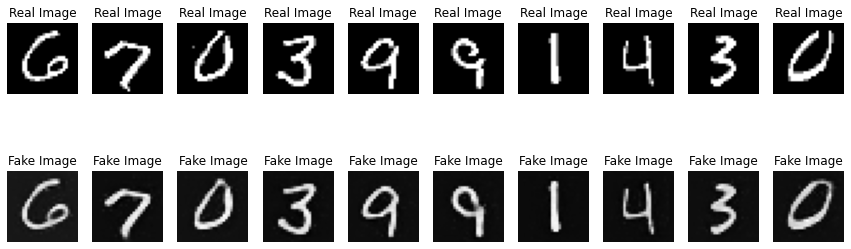

In [27]:
import random
fake_imgs = (fake_imgs.cpu().numpy()*std) + mean
test_imgs = (test_imgs.cpu().numpy()*std) + mean
num_samples_to_plot = 10
indices_to_plot = random.sample(range(len(fake_imgs)), num_samples_to_plot)
fig, axs = plt.subplots(2, num_samples_to_plot, figsize=(15, 5))

for i, idx in enumerate(indices_to_plot):
    fake_img = fake_imgs[idx]
    test_img = test_imgs[idx]

    axs[1, i].imshow(fake_img[0], cmap='gray')  # Assuming the images are grayscale
    axs[1, i].set_title('Fake Image')

    axs[0, i].imshow(test_img[0], cmap='gray')  # Assuming the images are grayscale
    axs[0, i].set_title('Real Image')

# Hide the x and y ticks for all subplots
for ax in axs.ravel():
    ax.axis('off')

plt.show()


In [28]:
# Extract the decoder from your 'AE' model
decoder_model = model.decoder
encoder_model = model.encoder


In [29]:
encoder_model.eval()
with torch.no_grad():
    for test_imgs in test_loader:
        break
    image = test_imgs
    test_imgs = Variable(test_imgs).float().to(device)
    latent_codes = encoder_model(test_imgs)

print(latent_codes)

latent_codes.shape

tensor([[ -613.2687,   284.7115,   708.8485,   270.3345,   -88.4408,  -246.9651,
           114.3930,   195.4268,   208.5508,   419.3686,   188.9114,  -209.8627,
          -429.8474,  -466.6710,  -442.3285,   429.9695,   168.0609,  -326.8277,
           233.9981,   934.8972,    59.6936,   -12.1343,    34.1171,   157.9160,
           360.9334,   102.8631,  -628.1505,    52.3554,   134.1058,    22.9643,
           271.1779,   157.5600],
        [  -86.2105,  -385.9734,   697.4398,  -201.6272,   200.4761,  -322.5945,
          -669.4662,    97.9900,   433.3500,   273.7502,   353.1738,  -116.4512,
          -439.1257,    94.5350,   752.7126,   426.9158,   114.9558,  -426.3748,
          -438.6568,   317.2352,   -65.3406,   232.4801,   200.9922,  -137.0525,
          -380.0219,  -164.3215,  -946.1644,  -474.7784,  -191.3195,   -62.0545,
           319.1205,   291.4200],
        [  488.3932,   -41.6292,   399.2448,   312.3319,   580.5169,   596.5911,
           250.0112,   -98.7582,   -23.81

torch.Size([20, 32])

In [30]:
decoder_model.eval()
with torch.no_grad():
        latent_codes = Variable(latent_codes).float().to(device)
        fake_img = decoder_model(latent_codes)


In [31]:
fake_img.shape

torch.Size([20, 1, 28, 28])

In [32]:
image.shape

torch.Size([20, 1, 28, 28])

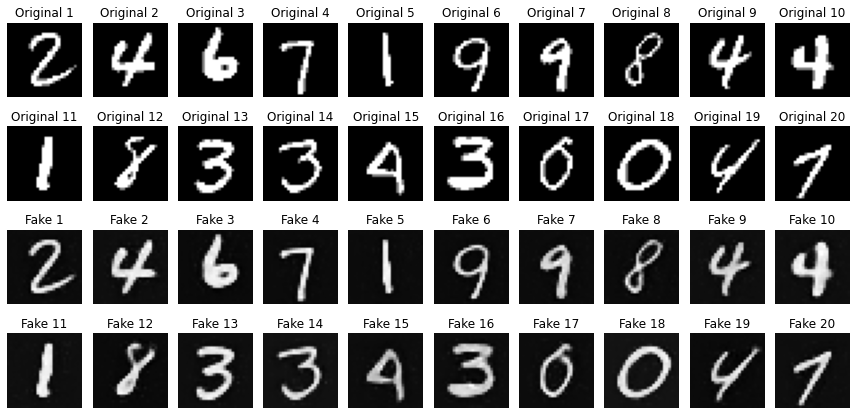

In [33]:
# Define the number of rows and columns for subplots
rows, cols = 4, 10  # Assuming you want to create a 4x10 grid

plt.figure(figsize=(12, 6))

for i in range(20):
    # Convert the tensors to NumPy arrays and reshape if necessary
    fake_img_np = (fake_img[i].squeeze().cpu().numpy() * std) + mean
    image_np = (image[i].squeeze().cpu().numpy()  * std) + mean

    # Plot the original image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    # Plot the fake image for comparison
    plt.subplot(rows, cols, i + 1 + 20)
    plt.imshow(fake_img_np, cmap='gray')
    plt.title(f'Fake {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
latent_codes.dtype

torch.float32